In [697]:
# augmentation_debugging.ipynb (convertible into Jupyter notebook cells)

# ------------------------------
# Cell 1: Imports and Constants
# ------------------------------
import os
import random
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Set paths
IMG_DIR = Path("/home/ulixes/segmentation_cv/data_augmentation/data/processed/Train/augmented/images")
MASK_DIR = Path("/home/ulixes/segmentation_cv/data_augmentation/data/processed/Train/augmented/masks")

# # Set paths
# IMG_DIR = Path("/home/ulixes/segmentation_cv/data_augmentation/data/processed/Train/color")
# MASK_DIR = Path("/home/ulixes/segmentation_cv/data_augmentation/data/processed/Train/label")

#Use /home/ulixes/segmentation_cv/data_augmentation/data/raw/Dataset_filtered/Test

# # Set paths
# IMG_DIR = Path("/home/ulixes/segmentation_cv/data_augmentation/data/processed/Test/color")
# MASK_DIR = Path("/home/ulixes/segmentation_cv/data_augmentation/data/processed/Test/processed_labels")


# # Set paths for testing resized 
# IMG_DIR = Path("/home/ulixes/segmentation_cv/data_augmentation/data/processed/Train/resized")
# MASK_DIR = Path("/home/ulixes/segmentation_cv/data_augmentation/data/processed/Train/resized_label")

# Sanity check
assert IMG_DIR.exists() and MASK_DIR.exists(), "Image or Mask directory not found."


In [698]:
# ------------------------------
# Cell 2: Count File Distributions
# ------------------------------
import re
from collections import Counter

files = [f for f in os.listdir(IMG_DIR) if os.path.isfile(IMG_DIR / f)]
print(f"Total image files: {len(files)}")

# Count by augmentation number
aug_counter = Counter()
for filename in files:
    match = re.search(r'_aug(\d+)', filename)
    if match:
        aug_num = int(match.group(1))
        aug_counter[aug_num] += 1
    else:
        aug_counter['no_aug'] += 1

print("\nFiles by augmentation number:")
for aug_num, count in aug_counter.items():
    print(f"  aug{aug_num}: {count}")

# Count cat vs dog images
cat_breeds = ['abyssinian', 'bengal', 'birman', 'bombay', 'british', 'egyptian', 
              'maine', 'persian', 'ragdoll', 'russian', 'siamese', 'sphynx']

cat_count = 0
dog_count = 0

for filename in files:
    filename_lower = filename.lower()
    is_cat = any(breed in filename_lower for breed in cat_breeds)
    if is_cat:
        cat_count += 1
    else:
        dog_count += 1

print(f"\nCat images: {cat_count}")
print(f"Dog images: {dog_count}")

Total image files: 8721

Files by augmentation number:
  aug4: 948
  aug1: 2938
  aug2: 2939
  aug3: 948
  aug5: 948

Cat images: 4740
Dog images: 3981


In [699]:
def visualize_pair(img_path, mask_path):
    """Load and visualize an image-mask pair side-by-side with proper encoding handling"""
    image = cv2.imread(str(img_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(str(mask_path), cv2.IMREAD_UNCHANGED)

    #Shape of the mask
    print(f"Shape of the mask: {mask.shape}")

    # Check if this is an original or processed mask
    unique_values = np.unique(mask)
    print(f"Original unique values: {unique_values}")

    if mask.ndim == 3:
        mask = mask[:, :, 0]  # Take first channel if 3D


    
    # Initialize normalized mask
    normalized_mask = np.zeros_like(mask)
    
    # Apply proper normalization based on which values are present
    if 128 in unique_values:  # Original masks with 128 for cats
        normalized_mask[mask == 128] = 1  # Cat
        # Look for dog value - could be various values
        if 64 in unique_values:
            normalized_mask[mask == 64] = 2  # Dog
        if 192 in unique_values:
            normalized_mask[mask == 192] = 2  # Dog
    else:  # Already processed masks with 1 for cats, 2 for dogs
        normalized_mask[mask == 1] = 1  # Cat
        normalized_mask[mask == 2] = 2  # Dog
    
    # Common values
    normalized_mask[mask == 255] = 255  # Border

    h, w = normalized_mask.shape
    colored_mask = np.zeros((h, w, 3), dtype=np.uint8)
    colored_mask[normalized_mask == 1] = [255, 0, 0]    # Red for cats
    colored_mask[normalized_mask == 2] = [0, 255, 0]    # Green for dogs
    colored_mask[normalized_mask == 255] = [255, 255, 255]  # White for borders

    # Show side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(image)
    axs[0].set_title("Image")
    axs[0].axis("off")

    axs[1].imshow(colored_mask)
    axs[1].set_title(f"Mask (values: {unique_values})")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

In [700]:
# ------------------------------
# Cell 4: Random Sample Viewer
# ------------------------------
def show_random_batch(n=5):
    """Randomly sample and display n image-mask pairs"""
    samples = random.sample(files, n)
    for filename in samples:
        img_path = IMG_DIR / filename
        mask_path = MASK_DIR / filename.replace(".jpg", ".png")

        if not mask_path.exists():
            print(f"Mask not found for {filename}, skipping...")
            continue

        print(f"\nDisplaying {filename}")
        visualize_pair(img_path, mask_path)


Displaying pug_124_aug1.jpg
Shape of the mask: (512, 512)
Original unique values: [  0   2 255]


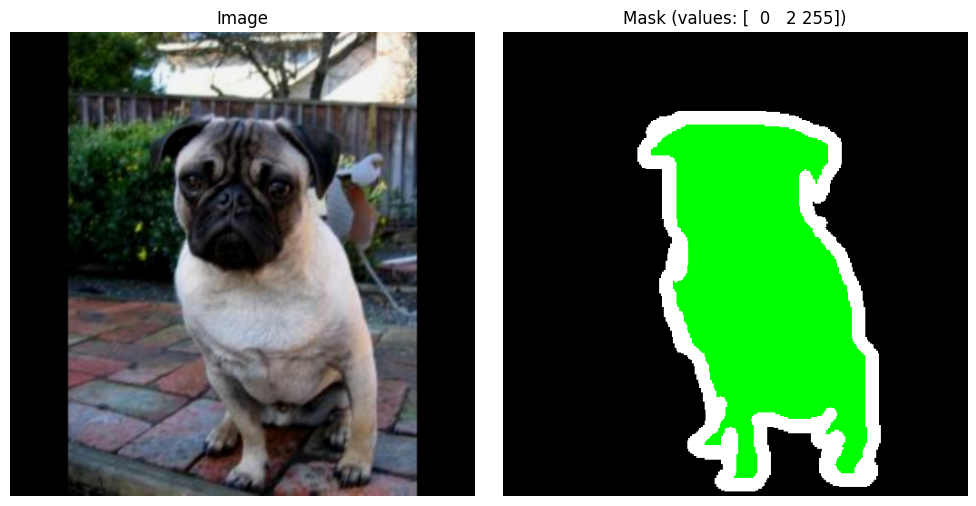


Displaying pomeranian_177_aug2.jpg
Shape of the mask: (512, 512)
Original unique values: [  0   2 255]


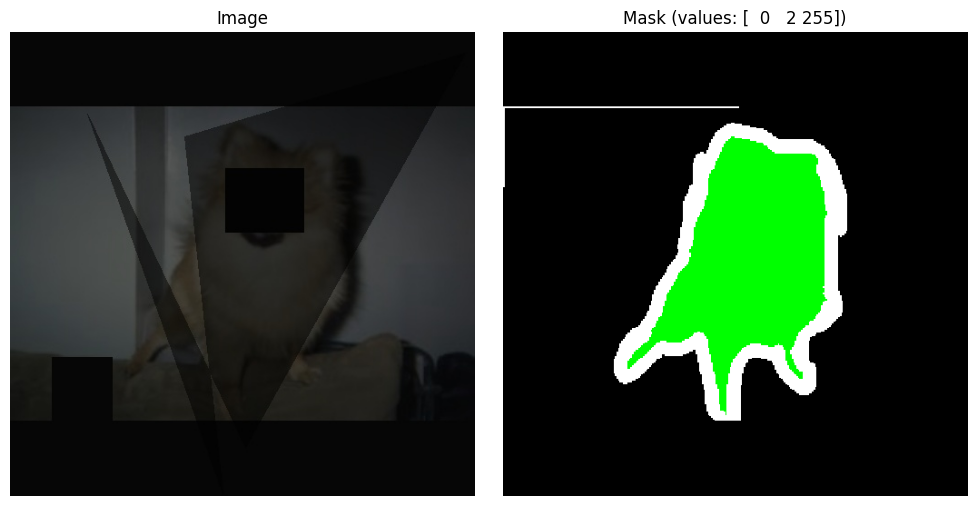


Displaying Ragdoll_186_aug3.jpg
Shape of the mask: (512, 512)
Original unique values: [  0   1 255]


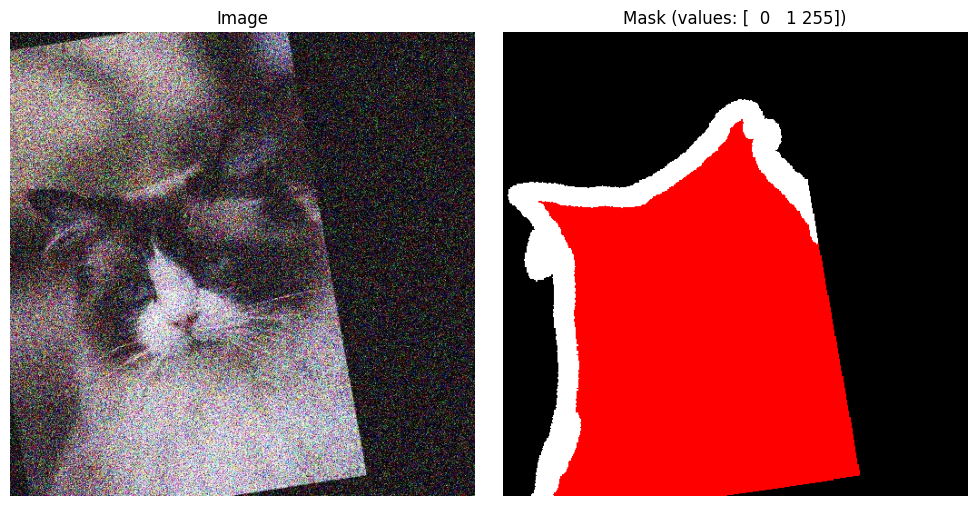


Displaying japanese_chin_147_aug1.jpg
Shape of the mask: (512, 512)
Original unique values: [  0   2 255]


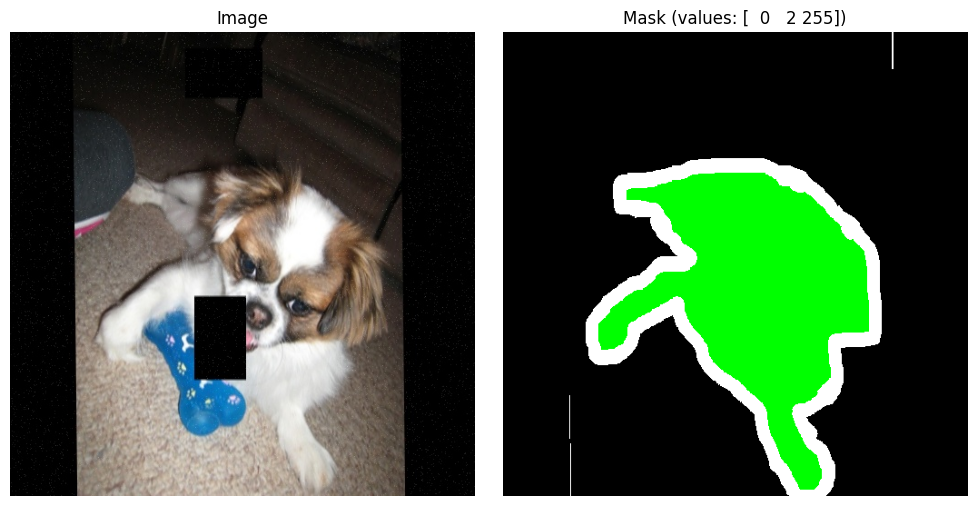


Displaying Maine_Coon_126_aug5.jpg
Shape of the mask: (512, 512)
Original unique values: [  0   1 255]


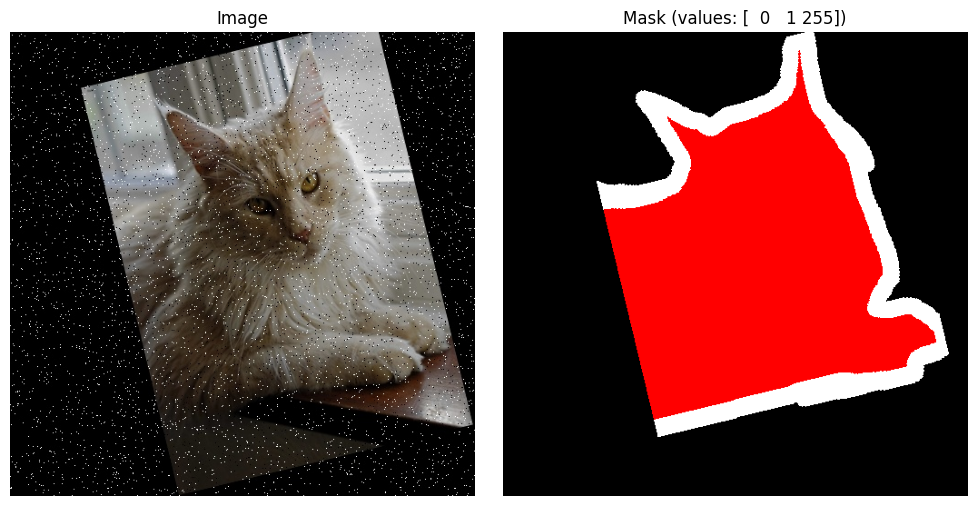

In [701]:
# ------------------------------
# Cell 5: Run Batch Visualization
# ------------------------------
show_random_batch(n=5)  # Change n as needed


In [702]:
# ------------------------------
# Cell 6: Sanity Check - Unique Mask Values
# ------------------------------
def print_mask_unique_values(n=10):
    """Print unique values in masks for n random samples."""
    for filename in random.sample(files, n):
        mask_path = MASK_DIR / filename.replace(".jpg", ".png")
        if not mask_path.exists():
            continue
        mask = cv2.imread(str(mask_path), cv2.IMREAD_UNCHANGED)
        if mask.ndim == 3:
            mask = mask[:, :, 0]
        print(f"{filename}: unique mask values = {np.unique(mask)}")

print_mask_unique_values()

pomeranian_165_aug1.jpg: unique mask values = [  0   2 255]
pomeranian_180_aug2.jpg: unique mask values = [  0   2 255]
Russian_Blue_143_aug4.jpg: unique mask values = [  0   1 255]
keeshond_189_aug1.jpg: unique mask values = [  0   2 255]
keeshond_167_aug2.jpg: unique mask values = [  0   2 255]
scottish_terrier_108_aug1.jpg: unique mask values = [  0   2 255]
Sphynx_125_aug5.jpg: unique mask values = [  0   1 255]
keeshond_185_aug1.jpg: unique mask values = [  0   2 255]
newfoundland_10_aug1.jpg: unique mask values = [  0   2 255]
Ragdoll_194_aug5.jpg: unique mask values = [  0   1 255]
